## Anthony Soroka
## CS 207 HW 7

## Q1. Median Maintenance using a Heap


### Part 1

Implement a "dominant heap" class `BinaryHeap`, which can handle both the min heap and the max heap cases, by having the constructor explicitly pass the "comparison" operator in. Replace min and del_min by dominant and del_dominant methods. Change the classmethod to also take in the operator.

In [1]:
from operator import gt, lt

#your code here

# Binary Heap that can handle min and max heaps 
# Should in fact be able to handle any operator

class BinaryHeap:
    
    ## Init Func, requires operator
    def __init__(self,op):
        self.storage=[None]
        self.upto=0
        self.op = op
    
    @classmethod
    def heapify_slow(cls, it, op):
        inst = cls(op) 
        for i in it:
            inst.insert(i)
        return inst
            
    def insert(self, value):
        # Insert to storage at end, sift_up from bottom
        self.storage.append(value)
        self.upto += 1
        self.sift_up(self.upto)

        
    def sift_up(self, i):
        parent = i // 2
        #switch i and parent if i dominates
        if parent > 0 and self.op(self.storage[i], self.storage[parent]):
                self.storage[i], self.storage[parent] = self.storage[parent], self.storage[i]
                self.sift_up(parent)
     
    def _dom_child(self, i):
        #Prior to calling this function, we have checked that at least one child exists
        #First confirm there are two childs.  
        #If not, return the lone child
        if 2*i + 1 > self.upto:
            return 2*i
        else:
            #Compare the two childs, return the dominant one
            if self.op(self.storage[2*i], self.storage[2*i+1]):
                return 2*i
            else:
                return 2*i +1
    
    def sift_down(self, i):
        #Check if we are at the bottom level
        if 2*i <= self.upto:
            # Compare i to child, swap if child is dominant
            child = self._dom_child(i)
            if self.op(self.storage[child],self.storage[i]):
                self.storage[child], self.storage[i] = self.storage[i], self.storage[child]
                self.sift_down(child)
        
    def dominant(self):
        return self.storage[1]

    
    def deldominant(self):
        dominantval = self.storage[1]
        self.storage[1], self.storage[self.upto] = self.storage[self.upto], self.storage[1]
        self.storage.pop()
        self.upto -= 1
        self.sift_down(1)
        return dominantval

In [2]:
data = [1,8,5,9,23,2,45,6,7,99,-5]

In [3]:
from operator import gt, lt

#test min Bin Tree
bh = BinaryHeap.heapify_slow(data, lt)
print(bh.storage)
bh.dominant()

[None, -5, 1, 2, 7, 6, 5, 45, 9, 8, 99, 23]


-5

In [5]:
# test max Bin Tree
bh = BinaryHeap.heapify_slow(data, gt)
print(bh.storage)
bh.dominant()

[None, 99, 45, 23, 7, 9, 2, 5, 1, 6, 8, -5]


99

### Part 2

Median maintenance is a very cool algorithm to find an online median.
We create two arrays to test our implementation, using np.median to test our answer...

In [10]:
import random
import numpy as np

#Use numpy to calc median on a random list
l = [random.randint(1,1000) for _ in range(90)]
print(len(l), np.median(l))
l2 = l + [random.randint(1,1000)]
print(len(l2), np.median(l2))

90 569.0
91 565.0


You will implement def online_median(iterator) which is a generator yielding successive values of your online median.

The algorithm is as follows:

We'll use 2 heaps, a max heap for the lower half of the data, and a min-heap for the upper half. We take the first 2values in our data and assign the smaller value to the max heap, while the larger value goes to the min-heap. Then, as we "insert" subsequent values in one of the two heaps, the following holds: if we keep the number of elements in both heaps equal (for the even case) or at-most differing by one, the median is respectively the average of the two dominants or the dominant in the heap with one extra item.

What then is our strategy for this balanced insertion? Quite simple really: if a new value is not as dominant as the dominant value, add it to that heap. If it is more dominant, add it to the other. If two items in a row get added to the same heap, the heaps will be out of balance by more than one. In this case, take the dominant element from the larger heap and simply add it to the smaller one.

In [7]:
#your code here

# Function calulates median on operator
# Uses two heaps, a min heap and a max heap
# Where the heaps dominant values determine the median
def online_median(iterator):
    n = 0 #counter to check if we are on first or second iter
    count = 0 #counter to check if we've added two consective items to a specific heap

    for value in iterator:
        n += 1
        
        #If first item, add item to both heaps
        if n == 1:
            bhMax = BinaryHeap.heapify_slow([value], gt)
            bhMin = BinaryHeap.heapify_slow([value], lt)
        
        #If second item, largest in minHeap, smallest in maxHeap
        elif n == 2:
            firstVal = bhMax.dominant()
            if firstVal < value:
                bhMin.deldominant()
                bhMin.insert(value)
            elif firstVal >= value:
                bhMax.deldominant()
                bhMax.insert(value)
                
        #If any other item insert into appropriate heap
        # ie if a new value is not as dominant as the heap's dominant value, add it to that heap.
        else:
            if value > bhMax.dominant():
                bhMin.insert(value)
                count += 1
            else:
                bhMax.insert(value)
                count -= 1
        
        ##Keep the two heaps Balanced
        
        #if added two consecutive values to Min Heap, move dominant to MaxHeap
        if count == 2:
            moveVal = bhMin.deldominant()
            bhMax.insert(moveVal)
            count = 0
        
        #if added two consecutive values to Max Heap, move dominant to MinHeap
        if count == -2:
            moveVal = bhMax.deldominant()
            bhMin.insert(moveVal)
            count = 0
        
        ##if MinHeap is bigger, Median is MinHeap's dominantValue
        if count == 1:
            myMedian = bhMin.dominant()
        
        ##if MaxHeap is bigger, Median is MaxHeap's dominantValue
        elif count == -1:
            myMedian = bhMax.dominant()
        
        ##if Heaps are balanced, Median is the average of the two heaps' dominantValues
        elif count == 0:            
            myMedian = (bhMax.dominant()+bhMin.dominant())/2
            
        yield myMedian

Do your answers match?


569.0


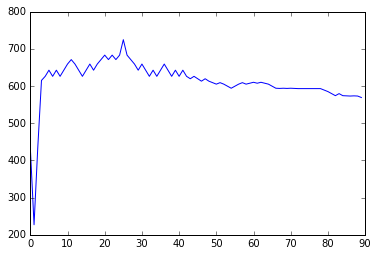

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

#Insure Online Version matches Numpy
medians = list(online_median(iter(l)))
print(medians[-1])
plt.plot(medians)

In [12]:
#Insure Online Version matches Numpy
list(online_median(iter(l2)))[-1]

565

Lastly, lets repeat the analysis we did last time on the randomly generated data.

In [13]:
from random import normalvariate, random
from itertools import count

#Create Randomly Generated Data
def make_data(m, stop=None):
    for _ in count():
        if stop and _ > stop:
            break
        yield 1.0e09 + normalvariate(0, m*random() )

In [14]:
#Insure online_median works on Randomly Generated Data
g = online_median(make_data(5, 100))
print(type(g))
out = list(g)
out[-10:]

<class 'generator'>


[999999999.7760007,
 999999999.787096,
 999999999.7760007,
 999999999.787096,
 999999999.797992,
 999999999.787096,
 999999999.797992,
 999999999.8088878,
 999999999.797992,
 999999999.8088878]

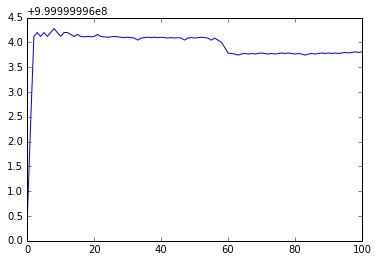

In [15]:
plt.plot(out)

## Q2

### Simulating a flight check-in counter

It is your job to simulate a flight-checkin counter. There are m agents handling n passengers. The passengers arrive in line with in-between time given by an exponential distribution for INTER_ARRIVAL_TIME. Each passenger, once he or she gets to a counter, is processed in a time drawn from an exponential distribution with PROCESSING_TIME. 

Clearly, in the usual case of 3-4 agents and 200+ customers on a flight, the customer waits much longer. We have been hired by the airlines customer-relations group to see how many extra agents must we hire to reduce waiting times by how much.

We start by representing each customer by a co-routine, which starts with the `inline` event. The state changes to the `atcounter` event, and then `ptime` seconds later, to the `leaves` event. Notice how this customer "process" is stopped at the yield, until the customer can be handled.

In [16]:
import collections, random
Event = collections.namedtuple('Event', 'time cid action agent')

#Generator of Customer Processes
def customer_process(idee, start, ptime):
    t, agent = yield Event(start, idee, "inline", None)
    t, agent = yield Event(t, idee, "atcounter", agent)
    yield Event(t+ptime, idee, "leaves", agent)
            

The following function simply implements the draw from the exponential distribution for a given customer:

In [17]:
#Function that generates exponentially distrbuted customer arrival and service times
def duration(arr_time, service_time):
    return random.expovariate(1./arr_time), random.expovariate(1./service_time)


Here is out main simulation class. you will be filling in parts of this class.

The constructor sets up the simulation. Three queues are created, one for agents that become free, one priority queue for events so that they can be processed in the order recieved, and a backlog for queue for those customers waiting in line because no agent was available.

We set up all the customers in the constructor, with two dictionaries, one to hold the co-routines, and one to hold time metadata which we shall use to figure the average waiting time.

The `run` method is where all the action happens and is the one you will edit.

In [18]:
import queue
import logging
class Simulator:
    
    def __init__(self, n_agents, n_customers, INTER_ARRIVAL_TIME =1., PROCESSING_TIME=3., DEBUG=False ): 
        #queues
        self.free_agents = queue.Queue()
        self.backlog = queue.Queue()
        self.events=queue.PriorityQueue()
        #save the arguments
        self.n_customers = n_customers
        self.n_agents = n_agents
        self.intertime=INTER_ARRIVAL_TIME
        self.proctime=PROCESSING_TIME
        #dictionaries to hold customer process
        self.customers={}
        self.customer_meta={}
        self.logger = logging.getLogger("sim")
        if DEBUG:
            self.logger.setLevel(logging.DEBUG)
        else:
            self.logger.setLevel(logging.WARNING)
        #on the free_agents queue, we put all the agents, and thee time
        #they got free
        for i in range(n_agents):
            self.free_agents.put((i,0))
        #this tracks when each customer came in.          
        time_when_came=0.
        for j in range(n_customers):
            interarrtime, proctime = duration(self.intertime, self.proctime)
            time_when_came += interarrtime
            intuple = (j, time_when_came, proctime)
            c = customer_process(*intuple)
            self.logger.debug("Customer {}, arrived {}, will take {} at counter".format(*intuple))
            #add each customer to dictionaries
            self.customers[j]=c
            self.customer_meta[j]={'cid':j, 'start':time_when_came, 'finish':None}
        self.logger.debug("========ending init==============\n\n")
        self.max_time_when_came=time_when_came  

    def run(self, end_time):
        #we prime each customer co-routine at the start
        #and put that event in the events priority queue
        #Since an event is a tuple, the ordering will be by start time
        for cid, proc in sorted(self.customers.items()):
            first_event = next(proc)#prime
            self.events.put(first_event)#customer in line

        #start at time 0
        sim_time = 0
        while sim_time < end_time:
            myFlag = 1
            
            #we are done if no events and no backlog
            if self.events.empty() and self.backlog.empty(): 
                self.logger.debug('*** end of events and backlog***')
                break
            #if we have agents available and a backlog
            #take customer from backlog queue. This is equivalent
            #to taking customers from line
            if not self.backlog.empty() and not self.free_agents.empty():
                "YOUR CODE HERE"
                current_event = self.backlog.get()
                
                #the sim time from this branch will be false
                #as we get the old time the person in the line showed up
            else: #get current event in all other cases
                #his ensures that leave events are processed thus
                #freeing up agents
                "YOUR CODE HERE"
                current_event = self.events.get()
                
            sim_time, cid, action, agent = current_event
            
            #get the current customer process
            cproc = self.customers[cid]
                
            if action=='leaves':
                self.logger.debug(">>>Customer {} leaves, agent {} free at {}".format(cid, agent, sim_time))
                #an agent gets free. Put the time they got free on q
                #also update the metadata
                self.free_agents.put((agent[0], sim_time))
                self.customer_meta[cid]['finish']=sim_time
            elif action=='atcounter':
                self.logger.debug("Customer {} atcounter Agent {} at {}".format(cid, agent, sim_time))
                next_time = sim_time#processing time already in coroutine
            elif action=='inline':#the agent is None to start
                self.logger.debug('----------------------------------------------')
                self.logger.debug("Customer {}, arrived in line @ {}.".format(cid, sim_time))

                if self.free_agents.empty():
                    self.logger.debug("NO agents available, putting {} inline on backlog at {}".format(cid, sim_time))
                    "YOUR CODE HERE"
                    self.backlog.put(current_event)
                    myFlag = -1
                else:
                    self.logger.debug("{} agents available to serve.".format(self.free_agents.qsize()))
                    "YOUR CODE HERE"#handle both situations
                    #of getting from backlog or regular. The time in
                    #next_time which you will send in message to co-routine
                    #below are different
                    
                    #Get available agent
                    #Time Customer is scene is Max of Agent Availability and Customer Availability
                    agent = self.free_agents.get()
                    next_time = max(sim_time,agent[1])
                    self.logger.debug("Customer {} inline to be served by Agent {} at {}".format(cid, agent, next_time))
            
            if myFlag == 1:
                #drive the co-routine by sending in time and agent, and getting
                #next event out. The event is put into the priority queue.
                try:
                    next_event = cproc.send((next_time, agent)) 
                except StopIteration:
                    del self.customers[cid] 
                else:
                    self.events.put(next_event)
    
    #Function calculates customer total process time
    def compute_ptimes(self):
        ptimes=[]
        for j in range(self.n_customers):
            if self.customer_meta[j]['finish']!=None:
                ptimes.append(self.customer_meta[j]['finish'] - self.customer_meta[j]['start'])
        return ptimes

In [19]:
#Simulator Helper Function
def sim_main(num_agents, num_customers, extratime=20., seed=None, debug=False):
    if seed is not None:
        random.seed(seed)
    sim = Simulator(num_agents, num_customers, DEBUG=debug)
    sim.run(sim.max_time_when_came+extratime)
    return sim

Start small to test this out.

In [20]:
#Print Debugs and Test Simulation on Simple Example
logger = logging.getLogger()
logger.addHandler(logging.StreamHandler())
sim=sim_main(2,6, debug=True)


Customer 0, arrived 1.2860696352892498, will take 0.25781615829951066 at counter
Customer 1, arrived 1.2872475268524601, will take 0.14923138853643883 at counter
Customer 2, arrived 1.702202417110288, will take 10.098382848122998 at counter
Customer 3, arrived 2.392495713300715, will take 0.1458782690644554 at counter
Customer 4, arrived 3.693161439816346, will take 0.8418049649715291 at counter
Customer 5, arrived 3.801230038822671, will take 0.3206803330909834 at counter
========ending init==============


----------------------------------------------
Customer 0, arrived in line @ 1.2860696352892498.
2 agents available to serve.
Customer 0 inline to be served by Agent (0, 0) at 1.2860696352892498
Customer 0 atcounter Agent (0, 0) at 1.2860696352892498
----------------------------------------------
Customer 1, arrived in line @ 1.2872475268524601.
1 agents available to serve.
Customer 1 inline to be served by Agent (1, 0) at 1.2872475268524601
Customer 1 atcounter Agent (1, 0) at 1.2

Now lets try it with some larger numbers.

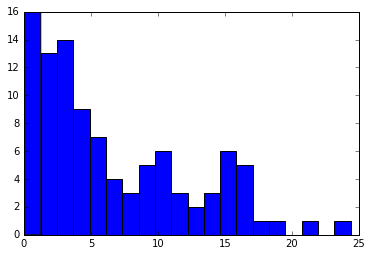

In [21]:
%matplotlib inline

#Single Simulation on a 3 Agents 100 Customers

import matplotlib.pyplot as plt
sim=sim_main(3,100)
plt.hist(sim.compute_ptimes(), bins=20);

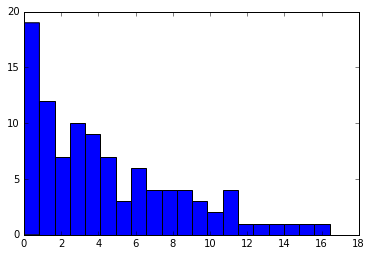

In [22]:
#Single Simulation on a 4 Agents 100 Customers

sim2=sim_main(4,100)
plt.hist(sim2.compute_ptimes(), bins=20);

extra time needed below as with 400 passengers a long time is taken to process.

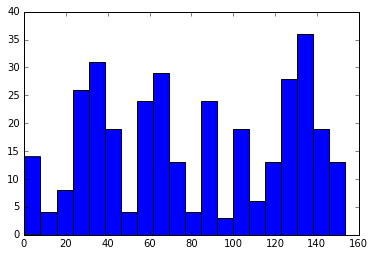

In [23]:
#Single Simulation on a 2 Agents 400 Customers

sim2=sim_main(2,400, extratime=100)
plt.hist(sim2.compute_ptimes(), bins=20);

For a proper statistical analysis, you would want to draw this multiple times and look at the distribution of the averages as well. But you should know what this distribution is :-).

** Analysis **

The distribution of the averages will be the Poisson distribution illustrated as per below.

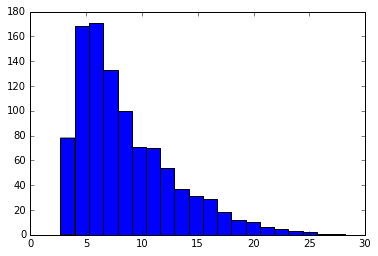

In [24]:
averages = np.array([])

#Simulation generating Average Process Time using 3 Agents and 100 Customers

for i in range(1000):
    sim=sim_main(3,100, extratime=100)
    averages = np.append( averages, np.mean(sim.compute_ptimes()))
plt.hist(averages, bins=20);

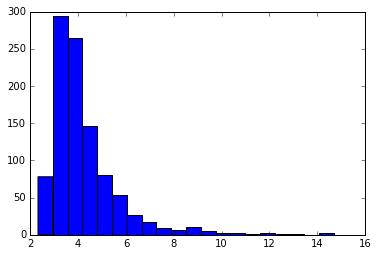

In [25]:
averages = np.array([])

#Simulation generating Average Process Time using 4 Agents and 100 Customers

for i in range(1000):
    sim=sim_main(4,100, extratime=100)
    averages = np.append( averages, np.mean(sim.compute_ptimes()))
plt.hist(averages, bins=20);

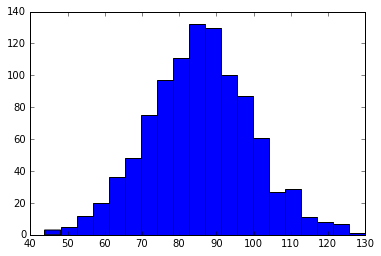

In [26]:
averages = np.array([])

#Simulation generating Average Process Time using 2 Agents and 400 Customers

for i in range(1000):
    sim=sim_main(2,400, extratime=100)
    averages = np.append( averages, np.mean(sim.compute_ptimes()))
plt.hist(averages, bins=20);